## 방법

1. 카카오톡 대화방에서 가장 친한 친구 또는 가장 많이 대화한 친구 1명 대화 내용을 다운로드 받아주세요.
    * 윈도우 pc 기준으로 [대화방] -> [설정] -> [대화 내용] -> [대화 내보내기] 단계로 다운로드 받아주세요.
    * mac에서 금지 (저장되는 형식이 다름)
2. 저장된 친구 이름으로 txt를 저장해주세요. (ex) 성록교수님짱짱.txt
3. 친구 이름을 순서대로 입력하여주세요.
    * 중복 된 친구 이름은 오류 발생
4. 평소에 자신이 욕 대신 사용하는 단어를 적어주세요. (ex) 시발 => 시방
    * 한 단어씩 입력하고 enter를 눌러주세요.
    * 더 이상 없는 경우 아무 것도 작성하지 않고 enter를 눌러주세요.
5. 배경 이미지 같은 경우에는 선택사항입니다.
    * 배경색이 흰색 혹은 투명색인 이미지가 정확하게 원하는 모양을 반영하기에 좋습니다


## 주의사항

1. 개인정보 보호 처리가 되어 있지 않습니다.
    * 주소, 계좌, 비밀번호 등 유출되지 않게 조심하세요.
    * 어떠한 데이터도 수집되지 않음.
2. hanspell 라이브러리를 사용하여 오타가 아닌 부분이 자동으로 수정되어 있을 수 있습니다.
    * 주로 사람 이름을 불렀을 경우 수정될 수 있습니다.
    * hanspell 라이브러리에 예외 사항으로 걸리는 경우 맞춤법 처리가 되지 않아 오류 데이터가 될 수 있습니다.
3. 너무 긴 대화는 시간이 매우 오래 걸립니다.
    * 2018년부터 2022년까지 모아온 자료를 돌려보았을 때 10분 이상 소요되는 것으로 보였습니다~
    * 긴 파일들은 10000개의 대화 기준으로 자르도록 하겠습니다. 10000개 기준 약 340초~400초 소요됨

In [1]:
# 모든 import

import time
import csv
from hanspell import spell_checker

from khaiii import KhaiiiApi
from konlpy.tag import Twitter, Kkma, Komoran

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

In [2]:
def all_input():
    os = input('다운로드 환경이 window이면 1번을, mac이면 2번을 입력하여 주세요 :')
    
    friend_name = input('친구의 카톡 닉네임을 입력하여 주세요 : ')

    my_name = input('자신의 카톡 닉네임을 입력하여 주세요 : ')
    
    line = set_file(os,friend_name,my_name)
    
    print("평소에 사용하는 비속어를 적어주세요. 없을 경우 '없음'을 입력하여 주세요.")
    
    while True:
        temp = input()
        if temp == '없음':
            break
        input_explicits.append(temp)
    set_explicits()
        
    print('원하는 배경 이미지가 있다면, 파일 이름을 입력하여 주세요. 없을 경우 "없음"을 입력하여 주세요.')
    mask_arr = input('이미지 파일 이름 입력 (.png 또는 .jpg 제외) :'  )
    
    if mask_arr != '없음':
        im = Image.open(f'{mask_arr}.png') # 이미지 파일 읽어오기
        mask_arr = np.array(im) # 픽셀 값 배열 형태 변환
    
    return os,friend_name,my_name,mask_arr

In [3]:
def set_file(os,f_name,m_name):
    line = []
    
    if os == '1':
        file = f_name+'.txt'
        with open(file, 'r', encoding="utf-8") as f:
            lines = f.readlines()
        line = [line for line in lines if '] [' in line]
        
    elif os == '2':
        file = f_name+'.csv'
        with open(file,newline='') as cf:
            lines = csv.reader(cf)
            for word in lines:
                line.append([word[1],word[2]])
    else:
        print('프로그램을 다시 실행하여 주세요.')
        
    return line

In [4]:
def replace_value(value):
    value = value.replace('사진\n', '').replace('이모티콘\n','').replace(
                '삭제된 메세지입니다', '').replace('ㅋ','').replace('ㅠ','').replace('ㅌ','')
    return value

In [5]:
def preProcess_line(text):
    
    start = time.time() 

    # 카톡 대화 내용이 많을 경우 제한사항
    if len(text) > 10000 :
        text = text[:10000]
    
    for value in text:
        name = value[0]
        sentence = value[1]
        sentence = replace_value(sentence)

        # 특수문자 제거
        sentence = ''.join(char for char in sentence if char.isalnum())

        if sentence == '':
            continue

        try:
            sentence = spell_checker.check(sentence).checked
            
        except Exception as e:
            print('예외 발생', value)
            
        finally:
            all_text.append(sentence)
            if name == friend_name:
                friend_text.append(sentence)
            elif name == my_name:
                my_text.append(sentence)
            else:
                print("친구 이름 또는 본인의 이름을 정확히 입력하여 주세요.")

    spend_time = time.time() - start
    return all_text,friend_text,my_text

In [28]:
# 카카오톡 khaiii 사용해보기

def kakao_khaiii(text,name):
    text_analyzed = []
    api = KhaiiiApi()

    for sentence in text:
        analyzed = api.analyze(sentence)
        for word in analyzed:
            for morph in word.morphs:
                if morph.tag == 'NNP'or morph.tag == 'NNG':
                    if len(morph.lex) > 1:
                        text_analyzed.append(morph.lex)

    counts = Counter(text_analyzed)
    tags = counts.most_common(40)
    text_analyzed = set(text_analyzed)

    make_cloud(dict(tags),name,'khaiii')

In [23]:
# khaiii를 통한 WordCloud 생성

def make_cloud(dict_text,name,text):
    if mask_arr == "없음":
        wc = WordCloud(font_path="/System/Library/Fonts/Supplemental/AppleGothic.ttf",background_color="white",
                       width = 700, height = 700, colormap = 'autumn', prefer_horizontal = True).generate_from_frequencies(dict_text)
    else :
            wc = WordCloud(font_path="/System/Library/Fonts/Supplemental/AppleGothic.ttf",background_color="white",
                   width = 700, height = 700, colormap = 'autumn', mask = mask_arr, prefer_horizontal = True).generate_from_frequencies(dict_text)
            
    plt.figure(figsize = (6, 6))  
    plt.imshow(wc)
    plt.title(f"{name}'s Word Frequency by {text}", size = 13)

    plt.axis('off')

    plt.show()
            

In [26]:
# Kkma를 사용해보기

def  use_Komoran(text,name):
    text_analyzed_Komoran = []
    komoran = Komoran()

    for sentence in text:
        text_analyzed_Komoran.extend(komoran.nouns(sentence))

    text_analyzed_Komoran = [n for n in text_analyzed_Komoran if len(n) > 1]
    counts= Counter(text_analyzed_Komoran)
    tags = counts.most_common(40)
    
    make_cloud(dict(tags),name,'Komoran')

In [9]:
def set_explicits():
    explicit_lines = ''
    my_explicits_dict = {}
    with open('my_dictionary.txt', 'r', encoding="utf-8") as f:
        explicit_lines = f.readlines()

    for value in explicit_lines:
        value = value[:-1]
        my_explicits.append(value)

    my_explicits.extend(input_explicits)

In [25]:
# 비속어 검사

def count_explciits(line,name):
    for value in line:
        if os == 1 :
            value = value.split('] ')[2].split(' ')
        elif os == 2 :
            value = value.split(' ')
        for word in value:
            if word in my_explicits:
                if word in my_explicits_dict:
                    my_explicits_dict[word] += 1
                else :
                    my_explicits_dict[word] = 1
    
    make_cloud(my_explicits_dict,name,'explicits')

In [16]:
def print_friend_result():
    kakao_khaiii(friend_text,friend_name)
    use_Komoran(friend_text,friend_name)

def print_my_result():
    kakao_khaiii(my_text,my_name)
    use_Komoran(my_text,my_name)

    
def print_all_result():
    kakao_khaiii(all_text,'우리')
    use_Komoran(all_text,'우리')
    count_explicits(all_text,'우리')
    analyzed_chat_for_fun()

# 모든 입력

1. 친구 이름
2. 평소에 자기가 사용하는 비속어
3. 배경 이미지

In [12]:
# 주요 변수들 모음

friend_name = ''
my_name = ''
file = ''
os = ''

my_explicits = []
input_explicits = []

spend_time = '' # 전체 대화 내용 소요 된 시간
mask_arr = '' #wordCloud 배경 이미지

lines = '' # 친구와의 카톡에 모든 대화 (전처리 과정 없음)
line = [] # 대화 내용을 포함한 라인의 list (년도 미포함, 부가 정보 미포함)

all_text = [] # 전처리 과정 이후 카톡의 모든 대화
my_text = [] # 전처리 과정 이후 내가 보낸 대화
friend_text = [] # 전처리 과정 이후 친구가 보낸 대화

os,friend_name,my_name,mask_arr = all_input()
line = set_file(os,friend_name,my_name)
all_text,friend_text,my_text = preProcess_line(line)

다운로드 환경이 window이면 1번을, mac이면 2번을 입력하여 주세요 :2
친구의 카톡 닉네임을 입력하여 주세요 : 김민제
자신의 카톡 닉네임을 입력하여 주세요 : 마경미
평소에 사용하는 비속어를 적어주세요. 없을 경우 '없음'을 입력하여 주세요.
없음
원하는 배경 이미지가 있다면, 파일 이름을 입력하여 주세요. 없을 경우 "없음"을 입력하여 주세요.
이미지 파일 이름 입력 (.png 또는 .jpg 제외) :없음
친구 이름 또는 본인의 이름을 정확히 입력하여 주세요.
예외 발생 ['김민제', 'ㅅㅂ']


## 모든 결과 출력하기
1. 자연어 처리 하지 않은 wordCloud 이미지
2. 자연어 처리 한 wordCloud 이미지
3. 자신이 사용한 비속어 wordCloud 이미지
4. 친구가 사용한 비속어 wordCloud 이미지
5. 자신이 사용한 비속어 횟수에 대한 보고서 출력

* 친구는 삭제할지 고민 중!


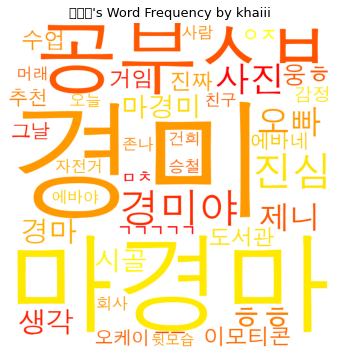

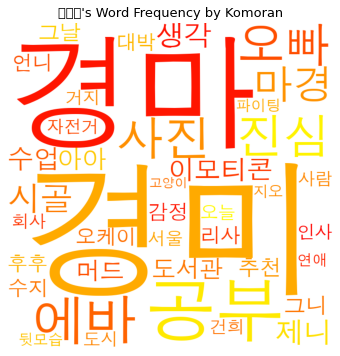

In [30]:
print_friend_result()

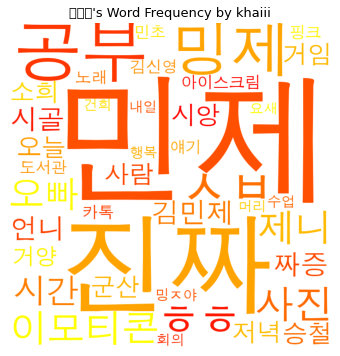

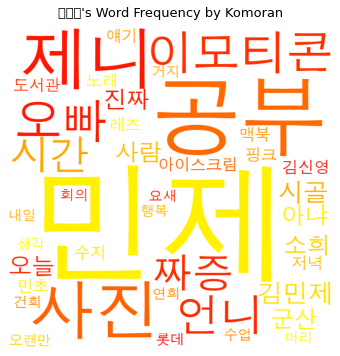

In [29]:
print_my_result()

## print_all_result()